# Miniproject-DQN Notebook
### Paul Boulenger, Paul Devianne

## Part 1: Introduction


In [1]:
#We import all necessary packages
import sys

import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn



%load_ext autoreload
%autoreload 2
%matplotlib inline


### Question 1.a

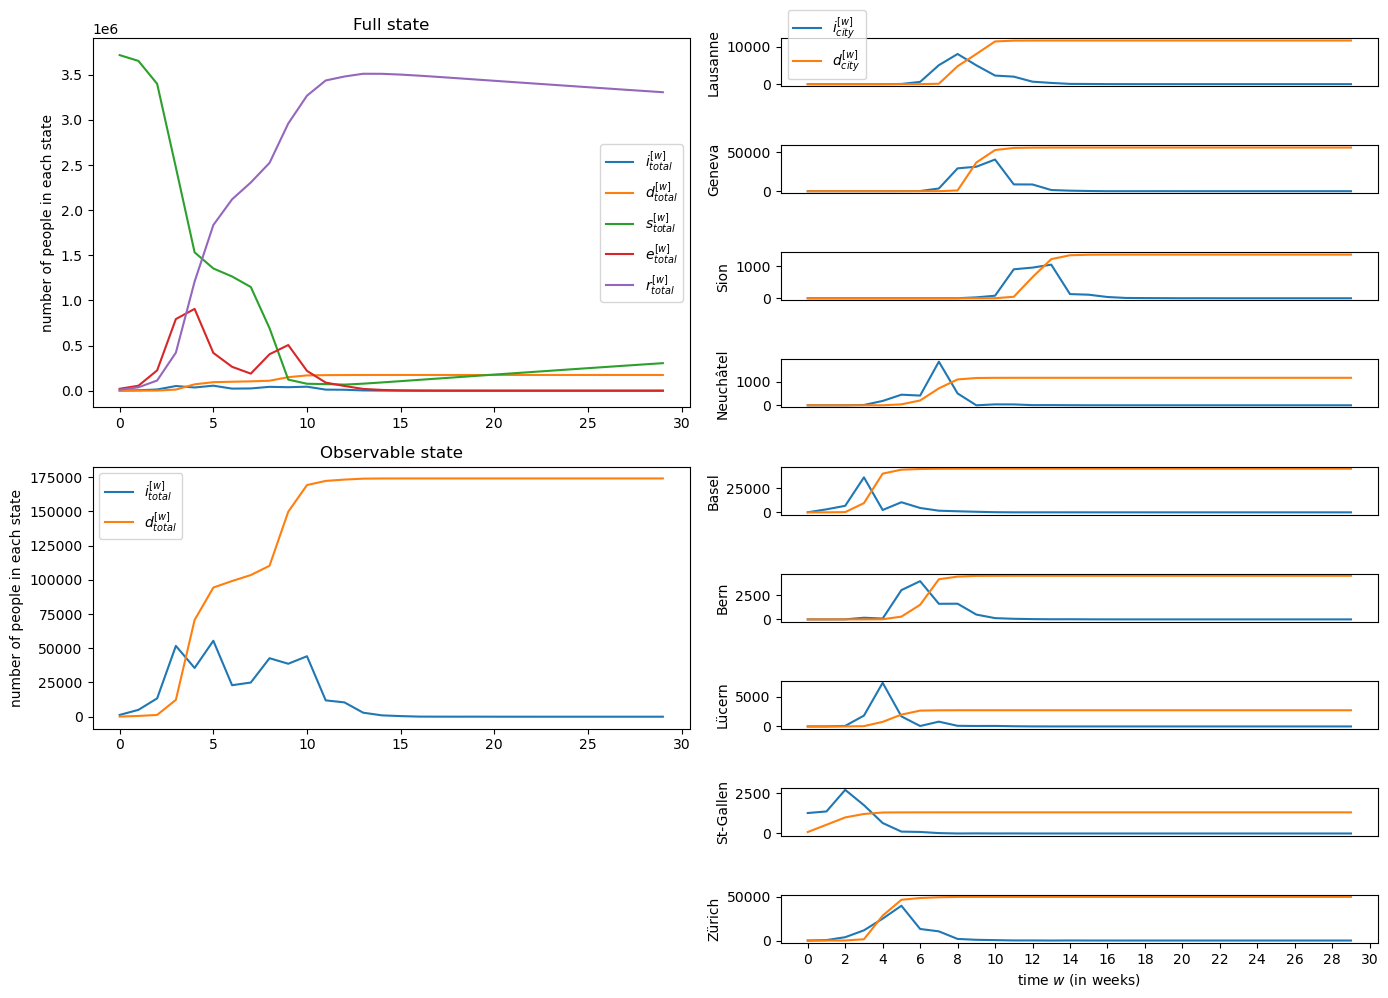

In [2]:
from utils import run_episode, action_preprocessor, run_episode, plot_episode
from utils import NoAgent

"""Loading the environment"""
dyn = ModelDynamics('config/switzerland.yaml')

env = Env(dyn,
            action_preprocessor=action_preprocessor)

no_agent = NoAgent(env)

log , _ = run_episode(no_agent, env)

plot_episode(log, dyn)

## Part 2: Professor Russo's Policy

In [3]:
from epidemic_env.agent import RussoAgent

In [4]:
def observation_preprocessor_Russo(obs: Observation, dyn:ModelDynamics):
    infected=np.array([np.array(obs.city[c].infected) for c in dyn.cities])[:,6].sum()
    return infected

In [5]:
env = Env(dyn,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_Russo)

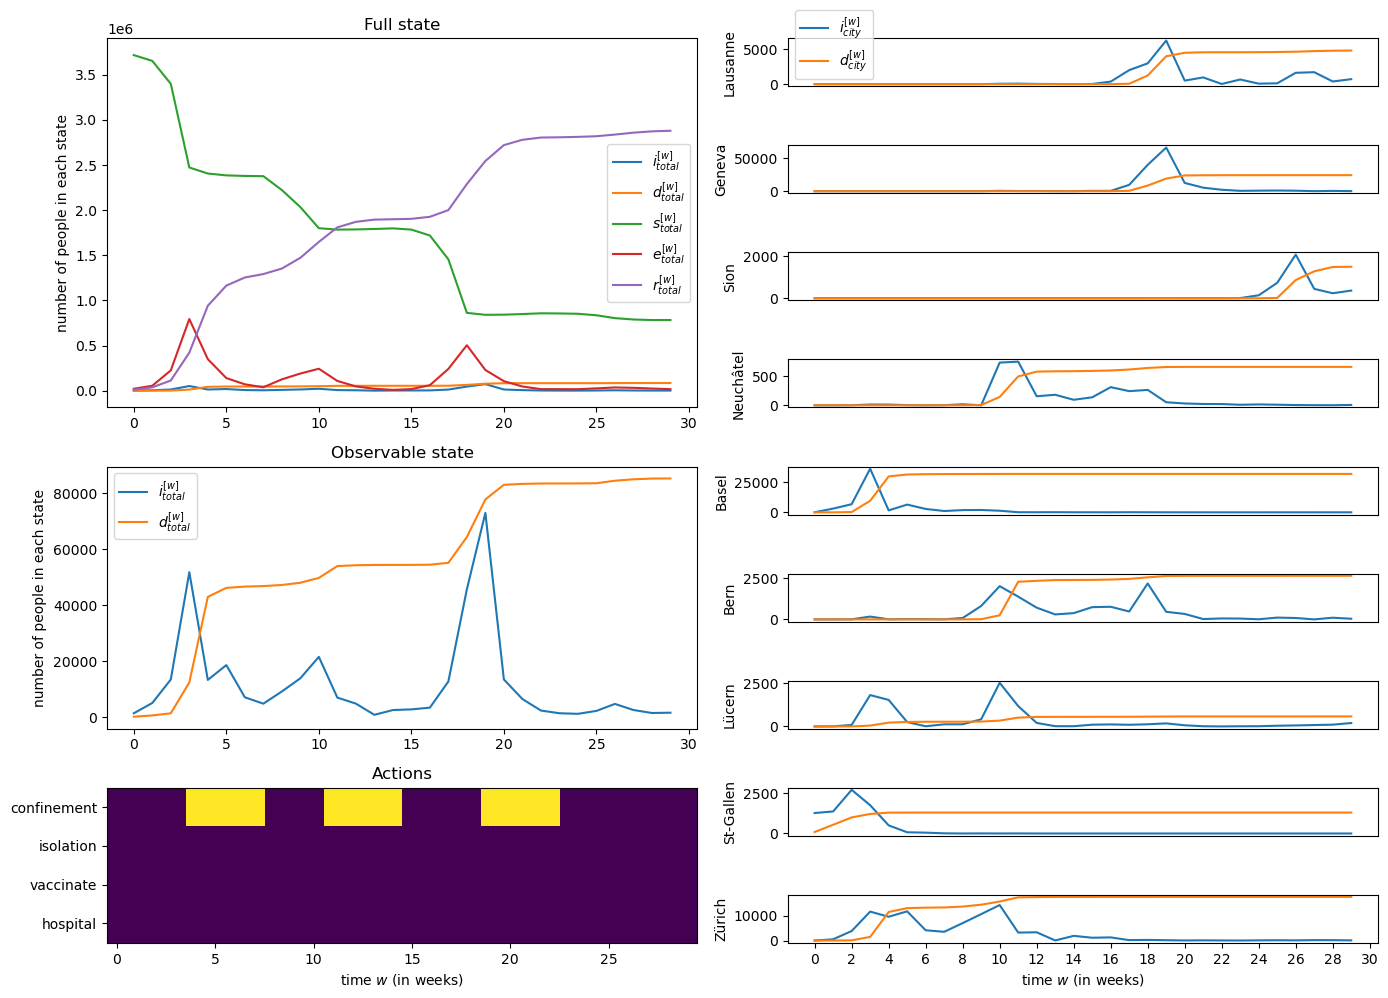

In [6]:
obs, info = env.reset(0)
agent = RussoAgent(env)

log, _ = run_episode(agent, env)
plot_episode(log, dyn, True)

## Part 3: A Deep Q-learning approach

## Part4: Dealing with a more complex action Space

## Part5: Wrapping Up